<a href="https://colab.research.google.com/github/ArmandOvanessians/Disorder/blob/main/Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00


In [1]:
!pip install torch torch-geometric networkx
import os
disorder_folder_path = '/content/drive/My Drive/Disorder'
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
import torch.nn.functional as F
import pickle
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GATConv, global_mean_pool
from google.colab import drive
import matplotlib.cm as cm

import os
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')
#graphs = '/content/drive/My Drive/Disorder/graphs_processed_labeled.pkl'
graphs = '/content/drive/My Drive/Disorder/Input_data/graphs_Kaia.pkl'
#graphs ="/content/graphs.pkl"
with open(graphs, 'rb') as f:
    graphs = pickle.load(f)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.4 MB/s eta 0:00:00
Mounted at /content/drive


In [33]:
# class GATWithMasking(nn.Module):
#     def __init__(self, num_features, hidden_dim, out_dim, num_heads=4):
#         super(GATWithMasking, self).__init__()

#         # GATConv layers
#         self.conv1 = GATConv(num_features, hidden_dim // num_heads, heads=num_heads, concat=True)
#         self.conv2 = GATConv(hidden_dim, out_dim, heads=1, concat=False)  # Output one attention head for the final layer

#         # BatchNorm and Dropout
#         self.bn1 = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm
#         self.bn2 = nn.BatchNorm1d(out_dim)
#         self.dropout = nn.Dropout(0.5)  # Add Dropout

#         # Fully connected layer for regression output
#         self.fc = nn.Linear(out_dim, 1)  # Output a single value (for regression)

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch

#         # Create a mask where 1 = valid, 0 = NaN (or missing)
#         mask = ~torch.isnan(x)

#         # Replace NaNs with 0 for computation
#         x = torch.nan_to_num(x, nan=0.0)

#         # Apply GATConv layers with batch normalization and dropout
#         x = F.relu(self.bn1(self.conv1(x, edge_index)))
#         x = self.bn2(self.conv2(x, edge_index))
#         x = global_mean_pool(x, batch)  # Pooling over the nodes in the same graph
#         x = self.dropout(x)

#         # Pass through final fully connected layer to output a single value
#         x = self.fc(x)
#         return x.view(-1)  # Ensure output shape is correct (batch size)

class GATWithMasking(nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim, num_classes, num_heads=4):
        super(GATWithMasking, self).__init__()

        # GATConv layers
        self.conv1 = GATConv(num_features, hidden_dim // num_heads, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1, concat=False)  # Output one attention head for the final layer

        # BatchNorm and Dropout
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(0.5)  # Add Dropout

        # Fully connected layer for classification output
        self.fc = nn.Linear(out_dim, num_classes)  # Output logits for num_classes

    def forward(self, x, edge_index):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Apply GATConv layers with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.bn2(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling over the nodes in the same graph
        x = self.dropout(x)

        # Pass through final fully connected layer to output logits for each class
        x = self.fc(x)
        return x  # Logits for each class

In [34]:
# Looking at feature importance of GAT
model = GATWithMasking(num_features=graphs[0].x.shape[1], hidden_dim=32,num_classes=2, out_dim=16)
# Load the state dictionary from the saved file
GAT_model_weights_path = '/content/drive/My Drive/Disorder/Models/model_test/best_gat_model.pth'
model.load_state_dict(torch.load(GAT_model_weights_path))
# Set the model to evaluation mode for inference
model.eval()

<ipython-input-34-c46367fe1c62>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(GAT_model_weights_path))


GATWithMasking(
  (conv1): GATConv(143, 8, heads=4)
  (conv2): GATConv(32, 16, heads=1)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)

In [2]:
class GATWithMasking(nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim, num_heads=4):
        super(GATWithMasking, self).__init__()

        # GATConv layers
        self.conv1 = GATConv(num_features, hidden_dim // num_heads, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1, concat=False)  # Output one attention head for the final layer

        # BatchNorm and Dropout
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(0.5)  # Add Dropout

        # Fully connected layer for regression output
        self.fc = nn.Linear(out_dim, 1)  # Output a single value (for regression)

    def forward(self, x, edge_index):
        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Apply GATConv layers with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.bn2(self.conv2(x, edge_index))

        # Use global mean pooling to aggregate node features into a graph-level feature
        x = global_mean_pool(x, batch)  # Aggregating features into graph-level features
        x = self.dropout(x)

        # Pass through the final fully connected layer to output a single value
        x = self.fc(x)
        return x.view(-1)  # Ensure output shape is correct (batch size)
# Looking at feature importance of GAT
model = GATWithMasking(num_features=graphs[0].x.shape[1], hidden_dim=64, out_dim=32)
# Load the state dictionary from the saved file
GAT_model_weights_path = '/content/drive/My Drive/Disorder/Models/GAT_trial_stratisfied_labelled/best_model.pth'
model.load_state_dict(torch.load(GAT_model_weights_path))
# Set the model to evaluation mode for inference
model.eval()

<ipython-input-2-8a49fc390266>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(GAT_model_weights_path))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Disorder/Models/GAT_trial_stratisfied_labelled/best_model.pth'

In [3]:
class GATWithMasking(nn.Module):
    def __init__(self, num_features, hidden_dim, out_dim, num_classes, num_heads=4):
        super(GATWithMasking, self).__init__()

        # GATConv layers
        self.conv1 = GATConv(num_features, hidden_dim // num_heads, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1, concat=False)  # Output one attention head for the final layer

        # BatchNorm and Dropout
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(0.5)  # Add Dropout

        # Fully connected layer for classification output
        self.fc = nn.Linear(out_dim, num_classes)  # Output logits for num_classes

    def forward(self, x, edge_index):
        #x, edge_index, batch = data.x, data.edge_index, data.batch

        # Create a mask where 1 = valid, 0 = NaN (or missing)
        mask = ~torch.isnan(x)

        # Replace NaNs with 0 for computation
        x = torch.nan_to_num(x, nan=0.0)

        # Apply GATConv layers with batch normalization and dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.bn2(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling over the nodes in the same graph
        x = self.dropout(x)

        # Pass through final fully connected layer to output logits for each class
        x = self.fc(x)
        return x  # Logits for each class

In [4]:
# Looking at feature importance of GAT
model = GATWithMasking(num_features=graphs[0].x.shape[1], hidden_dim=32, out_dim=16, num_classes=2)
# Load the state dictionary from the saved file
GAT_model_weights_path = '/content/drive/My Drive/Disorder/Models/model_test/best_gat_model.pth'
model.load_state_dict(torch.load(GAT_model_weights_path))
# Set the model to evaluation mode for inference
model.eval()

<ipython-input-4-e4dbec21c18c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(GAT_model_weights_path))


GATWithMasking(
  (conv1): GATConv(143, 8, heads=4)
  (conv2): GATConv(32, 16, heads=1)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)

## Testing

In [5]:
import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv

# Extracting the data object
# Assuming 'data' is your graph data containing x, edge_index, and batch
data = graphs[2]
x = data.x  # Node features
edge_index = data.edge_index  # Edge index
batch = data.batch  # Batch tensor

# Initialize the explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',  # Change to 'regression' for your graph-level output
        task_level='graph',  # Set to 'graph' since you're predicting at the graph level
        return_type='raw',  # Use 'raw' since you're dealing with regression
    ),
)


# Generate explanations using the entire data object
explanation = explainer(x, edge_index)  # Pass the entire data object
print(f'Generated explanations in {explanation.available_explanations}')

# Visualize feature importance (if applicable)
path_feature_importance = 'feature_importance.png'
explanation.visualize_feature_importance(path_feature_importance, top_k=10)
print(f"Feature importance plot has been saved to '{path_feature_importance}'")

# Visualize the graph (if applicable)
path_graph_visualization = 'subgraph.pdf'
explanation.visualize_graph(path_graph_visualization)
print(f"Subgraph visualization plot has been saved to '{path_graph_visualization}'")


Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
Subgraph visualization plot has been saved to 'subgraph.pdf'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a list to store all feature importance values across all graphs
all_feature_importances = []

# Loop through each graph in the dataset
l = 0
for i, data in enumerate(graphs):
    print(f"Processing graph {i+1}/{len(graphs)}")

    # Extract node features and edge index
    x = data.x
    edge_index = data.edge_index

    # Generate explanations using the explainer for each graph
    explanation = explainer(x, edge_index)

    # Extract feature importances (assuming you're using node mask for feature importance)
    feature_importance = explanation.node_mask.cpu().numpy()  # Move to CPU if necessary
    print(feature_importance)
    print(f"Feature importance shape: {feature_importance.shape}")

    # Store the feature importances for this graph
    #all_feature_importances.extend(feature_importance.flatten())  # Flatten and collect
    if l > 4:
      break
    l+=1
    path_feature_importance = f'importnace_{i+1}.pdf'
    explanation.visualize_feature_importance(path_feature_importance, top_k=60)
    #Optionally, save individual visualizations for each graph (can be commented out if not needed)
    path_graph_visualization = f'subgraph_{i+1}.pdf'
    explanation.visualize_graph(path_graph_visualization)
    print(f"Subgraph visualization plot saved to '{path_graph_visualization}'")

# # Now, plot the distribution of feature importances across all graphs
# plt.figure(figsize=(8, 6))
# plt.hist(all_feature_importances, bins=30, edgecolor='black', alpha=0.7)
# plt.title("Distribution of Feature Importances Across All Graphs")
# plt.xlabel("Feature Importance")
# plt.ylabel("Frequency")
# plt.grid(True)

# # Save the plot
# plt.savefig('feature_importance_distribution.png')
# plt.show()
# print(f"Feature importance distribution plot saved to 'feature_importance_distribution.png'")


Processing graph 1/556
[[0.12539276 0.12127745 0.16190016 0.         0.         0.20367241
  0.         0.         0.         0.         0.         0.
  0.         0.3157453  0.         0.         0.3240542  0.46992612
  0.37896815 0.32642472 0.         0.         0.         0.
  0.         0.         0.         0.         0.2212652  0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.22970548 0.         0.34280768
  0.         0.         0.         0.         0.38901308 0.32785368
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.23882441 0.44385785 0.22661433
  0.56987363 0.17782357 0.         0.25373238 0.32026926 0.31082612
  0.20048441 0.         0.23474634 0.         0.         0.30479762
  0.15918896 0.         0.30009028 0.1474908  0.         0.
  0.24917442 0.15582745 0.17983183 0.3320725  0.25265276 0.
  0.44740933 0.      

KeyboardInterrupt: 

In [ ]:
import pandas as pd
df_features = pd.read_csv('/content/drive/My Drive/Disorder/preprocessed_effector_scores.csv')
labels = df_features.columns[2:-3]
labels.shape

(98,)

In [15]:


labels = ['REP_Q2', 'REP_N2', 'REP_S2', 'REP_G2', 'REP_E2', 'REP_D2', 'REP_K2', 'REP_R2', 'REP_P2', 'REP_QN2',
'REP_RG2', 'REP_PR', 'REP_FG2', 'REP_SG2', 'REP_SR2', 'REP_KAP2', 'REP_PTS2', 'CLV_C14_Caspase3-7',
'DEG_APCC_KENBOX_2', 'DEG_Kelch_Keap1_1', 'DEG_SCF_TRCP1_1', 'DOC_ANK_TNKS_1', 'DOC_CYCLIN_RxL_1',
'DOC_MAPK_gen_1', 'DOC_MAPK_JIP1_4', 'DOC_MAPK_MEF2A_6', 'DOC_MAPK_NFAT4_5', 'DOC_PP1_RVXF_1',
'DOC_PP2A_B56_1', 'DOC_PP4_FxxP_1', 'DOC_WW_Pin1_4', 'LIG_14-3-3_CanoR_1', 'LIG_CaM_IQ_9',
'LIG_CtBP_PxDLS_1', 'LIG_EF_ALG2_ABM_1', 'LIG_EH_1', 'LIG_HCF-1_HBM_1', 'LIG_HOMEOBOX', 'LIG_KEPE_2',
'LIG_KLC1_WD_1', 'LIG_LIR_Gen_1', 'LIG_PAM2_1', 'LIG_PCNA_PIPBox_1', 'LIG_PDZ_Class_1',
'LIG_PDZ_Wminus1_1', 'LIG_PTAP_UEV_1', 'LIG_PTB_Apo_2', 'LIG_PTB_Phospho_1', 'LIG_Rb_LxCxE_1',
'LIG_SH2_CRK', 'LIG_SH2_GRB2like', 'LIG_SH2_NCK_1', 'LIG_SH2_SRC', 'LIG_SH2_STAP1', 'LIG_SH2_STAT5',
'LIG_SH3_2', 'LIG_SUMO_SIM_anti_2', 'LIG_SUMO_SIM_par_1', 'LIG_WRPW_1', 'MOD_CDK_SPK_2',
'MOD_CDK_SPxK_1', 'MOD_CDK_SPxxK_3', 'MOD_CK1_1', 'MOD_CK2_1', 'MOD_DYRK1A_RPxSP_1', 'MOD_GSK3_1',
'MOD_N-GLC_1', 'MOD_NMyristoyl', 'MOD_PIKK_1', 'MOD_PKA_1', 'MOD_PKA_2', 'MOD_PKB_1', 'MOD_Plk_1',
'MOD_ProDKin_1', 'MOD_SUMO_for_1', 'MOD_SUMO_rev_2', 'TRG_ER_diArg_1', 'TRG_ER_FFAT_1',
'TRG_LysEnd_APsAcLL_1', 'TRG_NES_CRM1_1', 'TRG_NLS_MonoExtN_4', 'A_homorep', 'C_homorep', 'D_homorep',
'E_homorep', 'G_homorep', 'H_homorep', 'I_homorep', 'K_homorep', 'L_homorep', 'M_homorep',
'N_homorep', 'P_homorep', 'Q_homorep', 'R_homorep', 'S_homorep', 'T_homorep', 'V_homorep',
'Y_homorep', 'FG_rich', 'PY', 'FRG', 'SGFYSG', 'PG_rich', 'ELASTIN_LIKE', 'FGxF', 'R_plus_Y',
'REP_RGG', 'AA_S', 'AA_P', 'AA_T', 'AA_A', 'AA_H', 'AA_Q', 'AA_N', 'AA_G', 'AA_R', 'AA_C', 'AA_D',
'AA_E', 'AA_F', 'AA_I', 'AA_K', 'AA_L', 'AA_M', 'AA_V', 'AA_W', 'AA_Y', 'acidic', 'basic',
'aliphatic', 'polar_fraction', 'chain_expanding', 'aromatic', 'disorder_promoting', 'net_charge',
'WF_complexity', 'KL_hydropathy', 'isoelectric_point', 'FCR', 'ED_ratio', 'RK_ratio', 'SCD']


In [17]:
graphs

[Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='ARNT2-1'),
 Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='ARNT2-2'),
 Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='ATF2-2'),
 Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='ATF2-5'),
 Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='CREB1-1'),
 Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='CREB1-2'),
 Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='CREB5-1'),
 Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='CREBZF-1'),
 Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='CREM-1'),
 Data(x=[2, 143], edge_index=[2, 2], idr_id=[2], y=[1], clone_id='CTCF-1'),
 Data(x=[4, 143], edge_index=[2, 12], idr_id=[4], y=[1], clone_id='CXXC1-2'),
 Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='DDIT3-1'),
 Data(x=[1, 143], edge_index=[2, 0], idr_id=[1], y=[1], clone_id='DLX1-2'),
 D

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the feature labels are available (you can generate them if not)
# If you know the specific names of the features, replace 'Feature i' with their names
feature_labels = [f'Feature {i}' for i in range(graphs[0].x.shape[1])]  # Example feature labels

# Initialize a dictionary to store feature importances for each feature label
feature_importances_by_label = {label: [] for label in feature_labels}
k = 0
# Loop through each graph in the dataset
for i, data in enumerate(graphs):
    print(f"Processing graph {i+1}/{len(graphs)}")

    # Extract node features and edge index
    x = data.x
    edge_index = data.edge_index

    # Generate explanations using the explainer for each graph
    explanation = explainer(x, edge_index)
    # path_feature_importance = f'importnace_A_{i+1}.pdf'
    # explanation.visualize_feature_importance(path_feature_importance, top_k=100)

    # Extract feature importances (assuming you're using node mask for feature importance)
    feature_importance = explanation.node_mask.cpu().numpy()  # Move to CPU if necessary
    print(f"Feature importance shape: {feature_importance.shape}")

    # Store the feature importances for this graph by feature label
    for idx, importance in enumerate(np.sum(feature_importance, axis=0)):  # Averaging across nodes
        feature_importances_by_label[feature_labels[idx]].append(importance)


#feature_importances_by_label.keys()
plt.figure(figsize=(10, 6))

# Convert feature importances to an array for plotting
means = [np.mean(np.nan_to_num(feature_importances_by_label[label], nan=0)) for label in feature_labels]


# Plot the means and standard deviations as a bar chart with error bars
plt.bar(labels, means, alpha=0.7, color='blue')
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances Across All Graphs")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()

# Save the plot locally
plt.savefig('feature_importance_distribution_by_label.png')
# Save plot to the explainer folder

plt.show()
print(f"Feature importance distribution plot saved to 'feature_importance_distribution_by_label.png'")


Processing graph 1/332
Feature importance shape: (2, 143)
Processing graph 2/332
Feature importance shape: (2, 143)
Processing graph 3/332
Feature importance shape: (2, 143)
Processing graph 4/332
Feature importance shape: (1, 143)
Processing graph 5/332
Feature importance shape: (1, 143)
Processing graph 6/332
Feature importance shape: (1, 143)
Processing graph 7/332
Feature importance shape: (2, 143)
Processing graph 8/332
Feature importance shape: (2, 143)
Processing graph 9/332
Feature importance shape: (1, 143)
Processing graph 10/332
Feature importance shape: (2, 143)
Processing graph 11/332
Feature importance shape: (4, 143)
Processing graph 12/332
Feature importance shape: (1, 143)
Processing graph 13/332
Feature importance shape: (1, 143)
Processing graph 14/332
Feature importance shape: (1, 143)
Processing graph 15/332
Feature importance shape: (2, 143)
Processing graph 16/332
Feature importance shape: (1, 143)
Processing graph 17/332
Feature importance shape: (2, 143)
Proces

NameError: name 'labels' is not defined

<Figure size 1000x600 with 0 Axes>

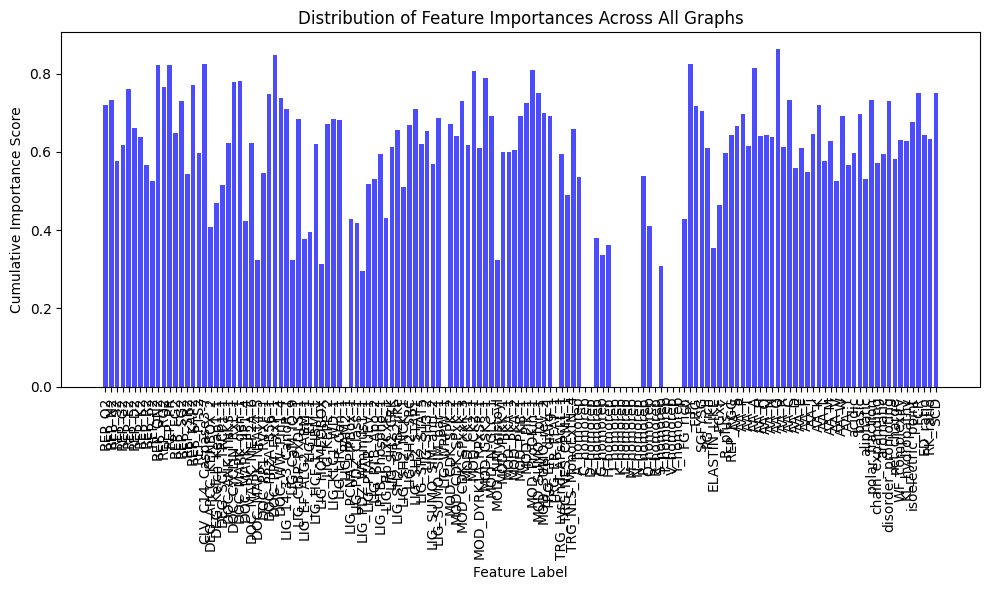

Feature importance distribution plot saved to 'feature_importance_distribution_by_label.png'


In [13]:
#feature_importances_by_label.keys()
plt.figure(figsize=(10, 6))

# Convert feature importances to an array for plotting
means = [np.mean(np.nan_to_num(feature_importances_by_label[label], nan=0)) for label in feature_labels]
#stds = [np.std(np.nan_to_num(feature_importances_by_label[label], nan=0)) for label in feature_labels]

# Plot the means and standard deviations as a bar chart with error bars
plt.bar(labels, means, alpha=0.7, color='blue')
plt.xticks(rotation=90)
plt.title("Distribution of Feature Importances Across All Graphs")
plt.xlabel("Feature Label")
plt.ylabel("Cumulative Importance Score")
plt.tight_layout()

# Save the plot
plt.savefig('feature_importance_distribution_by_label_.png')
plt.show()
print(f"Feature importance distribution plot saved to 'feature_importance_distribution_by_label.png'")

In [ ]:
# import pandas as pd
# df_features = pd.read_csv('/content/drive/My Drive/Disorder/preprocessed_effector_scores.csv')
# feature_names = list(df_features.columns[2:])

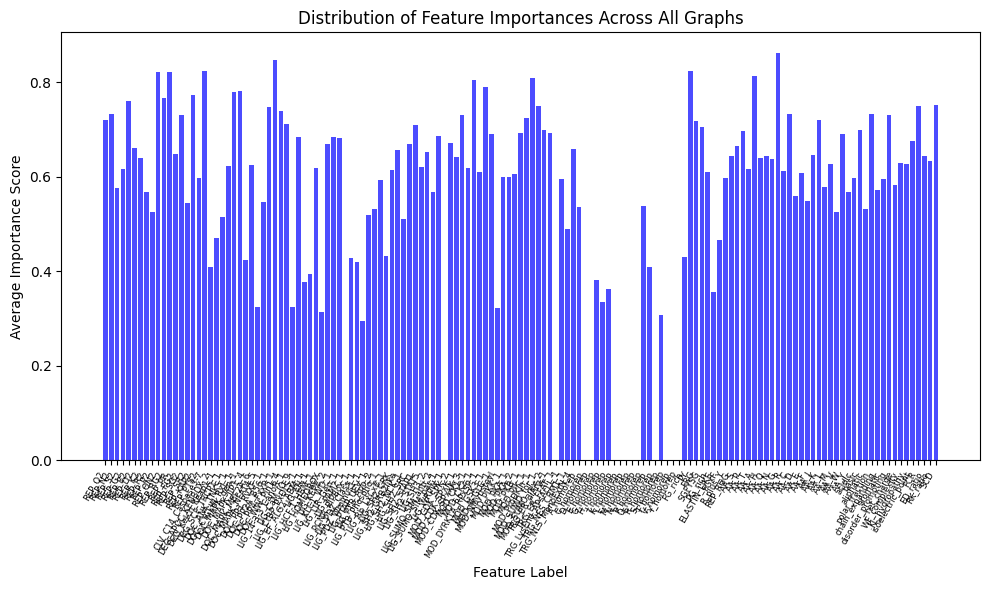

Feature importance distribution plot saved to 'feature_importance_distribution_by_label.png'


In [14]:
#feature_importances_by_label.keys()
plt.figure(figsize=(10, 6))

# Convert feature importances to an array for plotting
means = [np.mean(np.nan_to_num(feature_importances_by_label[label], nan=0)) for label in feature_labels]


# Plot the means and standard deviations as a bar chart with error bars
plt.bar(labels, means, alpha=0.7, color='blue')
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances Across All Graphs")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()

# Save the plot locally
plt.savefig('feature_importance_distribution_by_label.png')
# Save plot to the explainer folder

plt.show()
print(f"Feature importance distribution plot saved to 'feature_importance_distribution_by_label.png'")

Processing graph 1/332
Processing graph 2/332
Processing graph 3/332
Processing graph 4/332
Processing graph 5/332
Processing graph 6/332
Processing graph 7/332
Processing graph 8/332
Processing graph 9/332
Processing graph 10/332
Processing graph 11/332
Processing graph 12/332
Processing graph 13/332
Processing graph 14/332
Processing graph 15/332
Processing graph 16/332
Processing graph 17/332
Processing graph 18/332
Processing graph 19/332
Processing graph 20/332
Processing graph 21/332
Processing graph 22/332
Processing graph 23/332
Processing graph 24/332
Processing graph 25/332
Processing graph 26/332
Processing graph 27/332
Processing graph 28/332
Processing graph 29/332
Processing graph 30/332
Processing graph 31/332
Processing graph 32/332
Processing graph 33/332
Processing graph 34/332
Processing graph 35/332
Processing graph 36/332
Processing graph 37/332
Processing graph 38/332
Processing graph 39/332
Processing graph 40/332
Processing graph 41/332
Processing graph 42/332
P

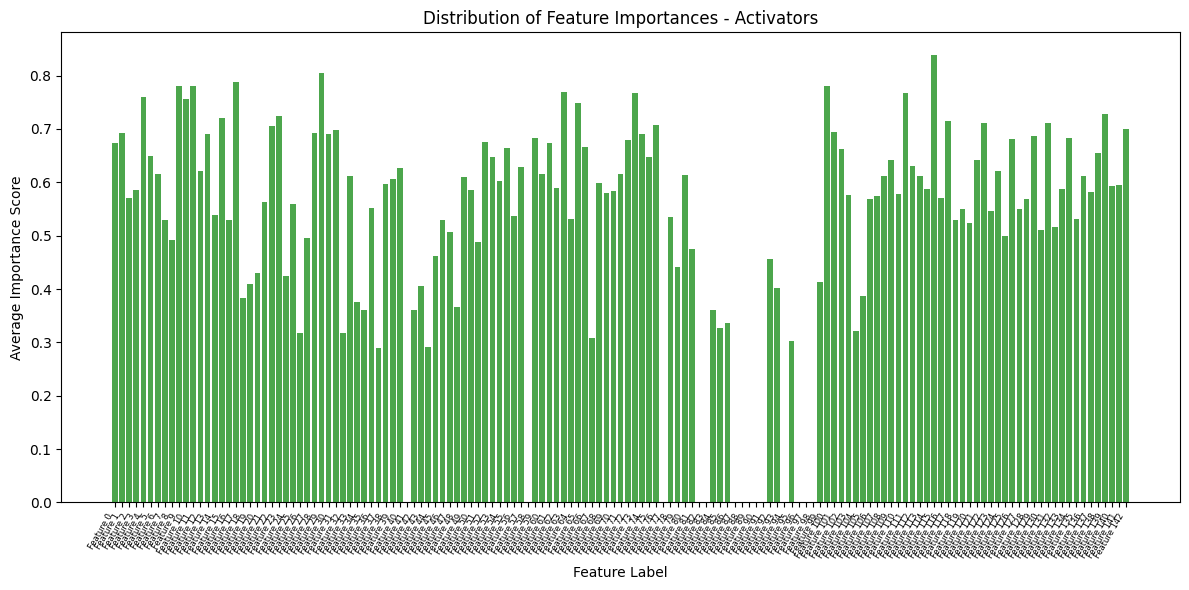

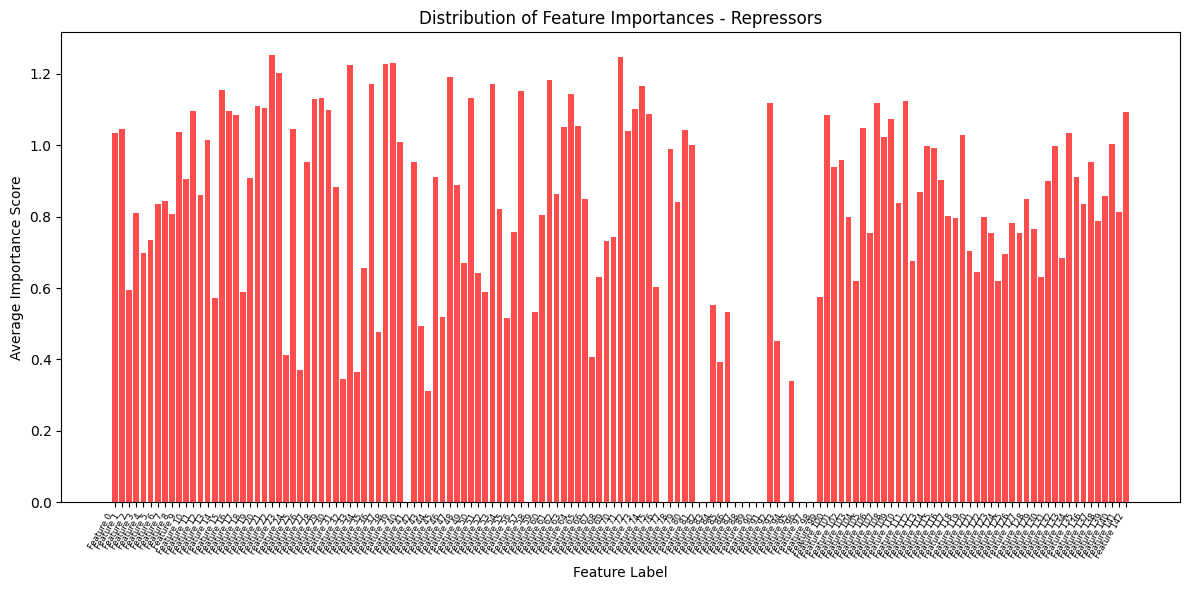

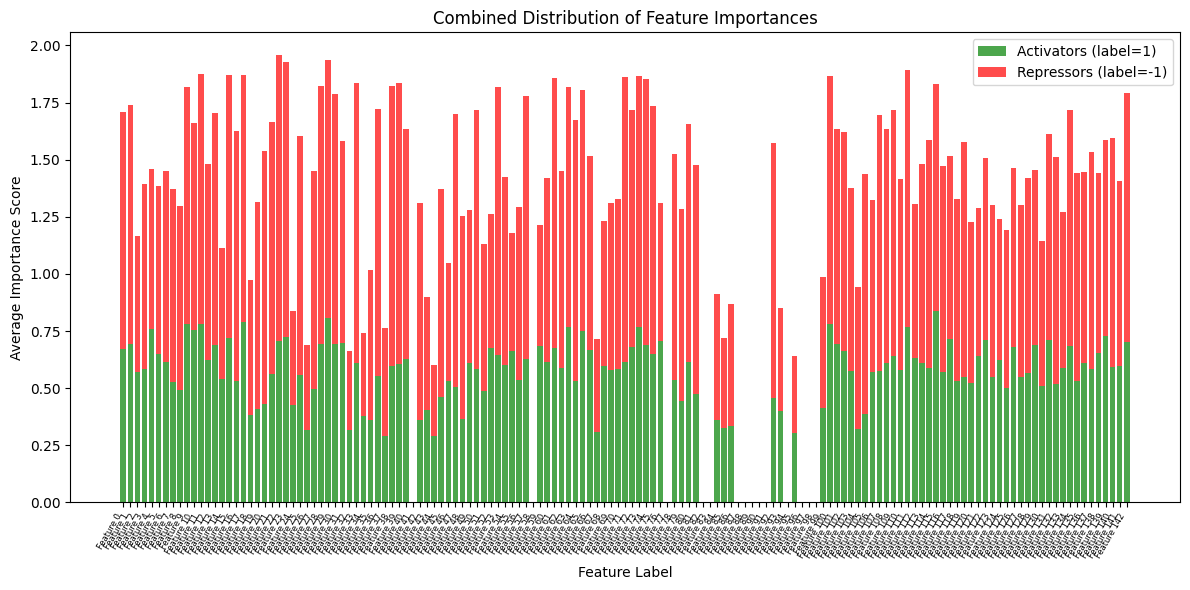

Feature importance distribution plots saved for activators, repressors, and combined.


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the feature labels are available (you can generate them if not)
feature_labels = [f'Feature {i}' for i in range(graphs[0].x.shape[1])]  # Example feature labels

# Initialize dictionaries to store feature importances for each label group
feature_importances_positive = {label: [] for label in feature_labels}
feature_importances_negative = {label: [] for label in feature_labels}

# Loop through each graph in the dataset
for i, data in enumerate(graphs):
    print(f"Processing graph {i+1}/{len(graphs)}")

    # Extract node features, edge index, and labels
    x = data.x
    edge_index = data.edge_index
    label = data.y.item()  # Assuming y is a single value for each graph

    # Generate explanations using the explainer for each graph
    explanation = explainer(x, edge_index)

    # Extract feature importances (assuming node mask is used for feature importance)
    feature_importance = explanation.node_mask.cpu().numpy()

    # Store the feature importances for this graph by feature label
    summed_importance = np.sum(feature_importance, axis=0)  # Summing across nodes

    if label == 1:
        # Grouping for activators (label == 1)
        for idx, importance in enumerate(summed_importance):
            feature_importances_positive[feature_labels[idx]].append(importance)
    elif label == -1:
        # Grouping for repressors (label == -1)
        for idx, importance in enumerate(summed_importance):
            feature_importances_negative[feature_labels[idx]].append(importance)

# Calculate means for both groups
means_positive = [np.mean(np.nan_to_num(feature_importances_positive[label], nan=0)) for label in feature_labels]
means_negative = [np.mean(np.nan_to_num(feature_importances_negative[label], nan=0)) for label in feature_labels]

# Plotting feature importances for activators and repressors separately
plt.figure(figsize=(12, 6))

# Plot for activators
plt.bar(feature_labels, means_positive, alpha=0.7, color='green', label='Activators (label=1)')
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances - Activators")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()
plt.savefig('feature_importance_distribution_activators.png')
plt.show()

# Plot for repressors
plt.figure(figsize=(12, 6))
plt.bar(feature_labels, means_negative, alpha=0.7, color='red', label='Repressors (label=-1)')
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances - Repressors")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()
plt.savefig('feature_importance_distribution_repressors.png')
plt.show()

# Combined plot
plt.figure(figsize=(12, 6))
plt.bar(feature_labels, means_positive, alpha=0.7, color='green', label='Activators (label=1)')
plt.bar(feature_labels, means_negative, alpha=0.7, color='red', label='Repressors (label=-1)', bottom=means_positive)
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Combined Distribution of Feature Importances")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.legend()
plt.tight_layout()
plt.savefig('feature_importance_distribution_combined.png')
plt.show()

print("Feature importance distribution plots saved for activators, repressors, and combined.")


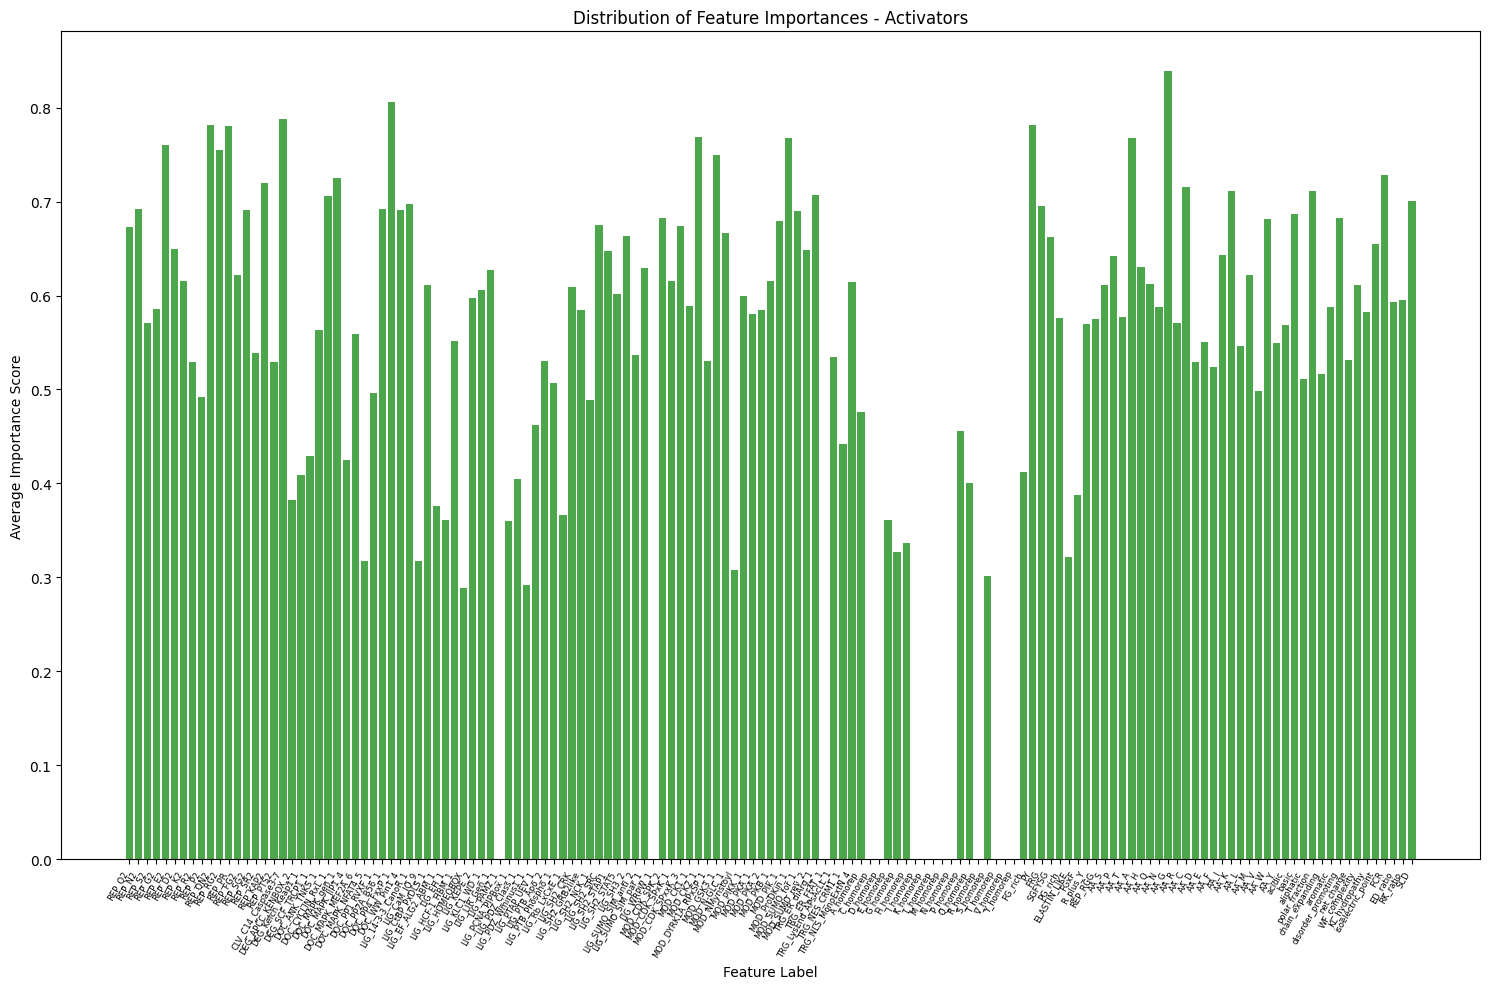

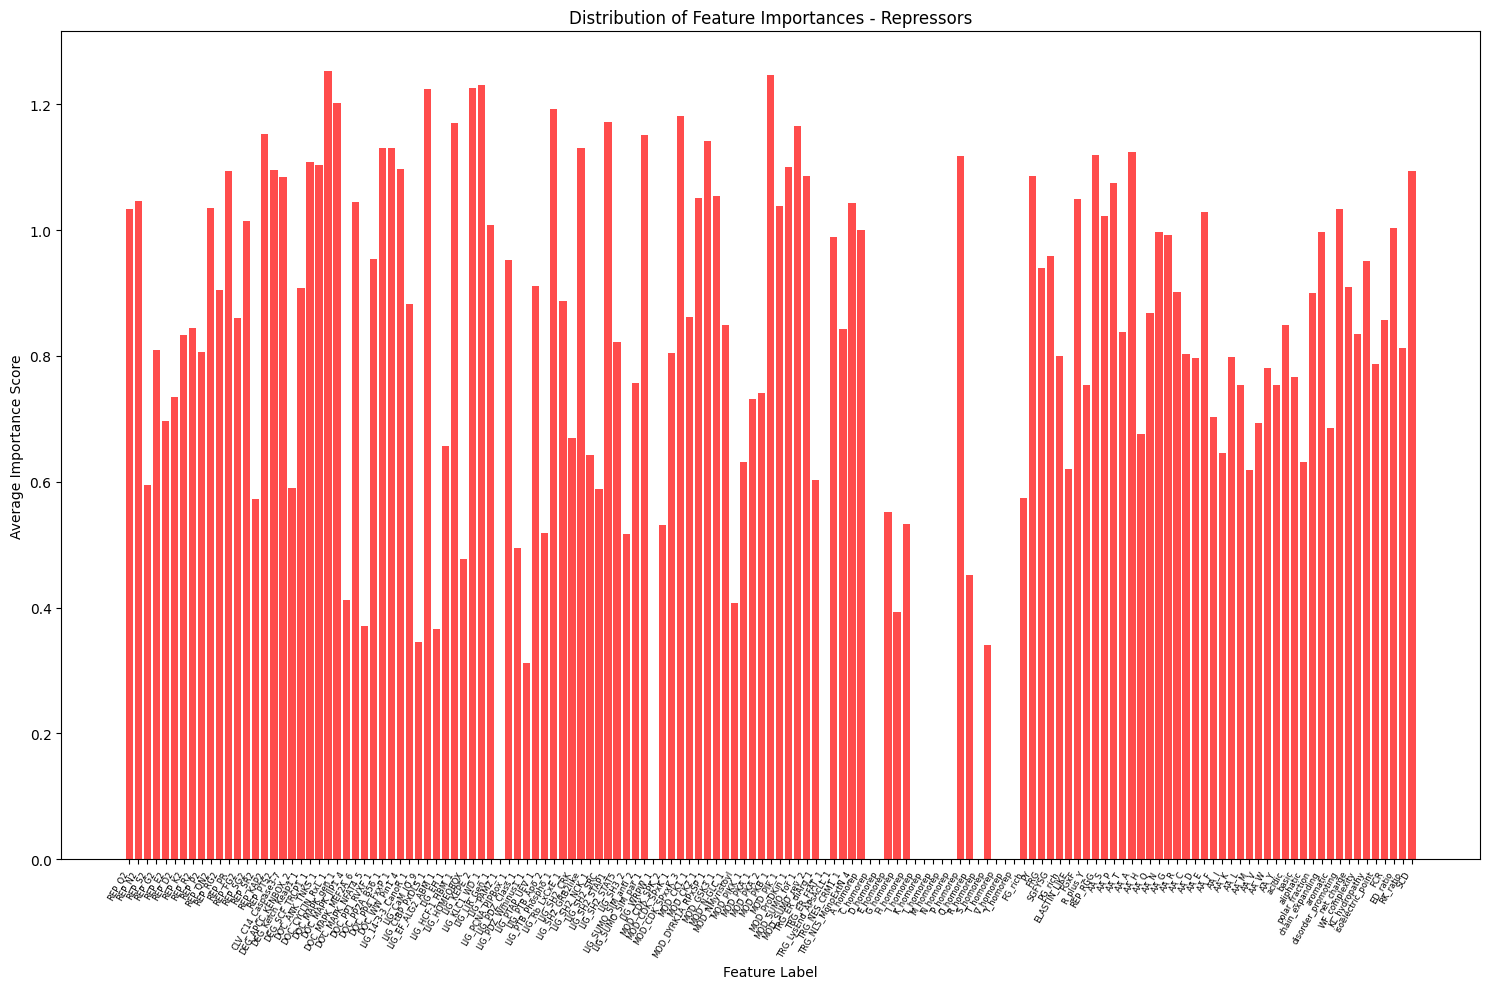

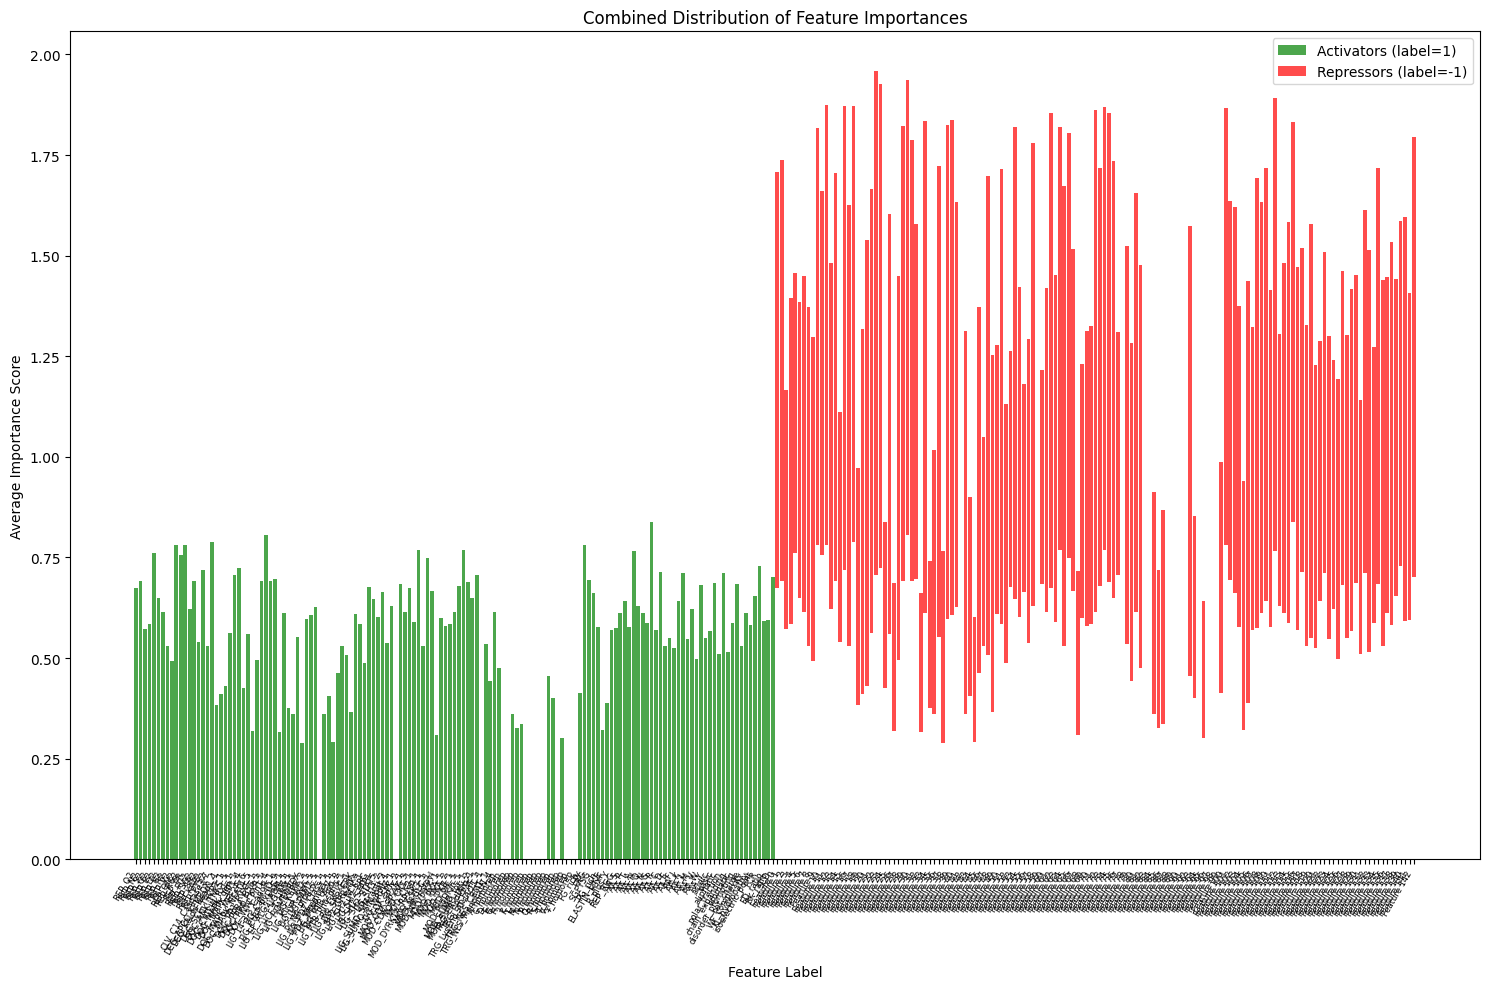

Feature importance distribution plots saved for activators, repressors, and combined.


In [23]:
# Plot for activators
# Plotting feature importances for activators and repressors separately
plt.figure(figsize=(15, 10))
plt.bar(labels, means_positive, alpha=0.7, color='green', label='Activators (label=1)')
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances - Activators")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()
plt.savefig('feature_importance_distribution_activators.png')
plt.show()

# Plot for repressors
plt.figure(figsize=(15, 10))
plt.bar(labels, means_negative, alpha=0.7, color='red', label='Repressors (label=-1)')
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances - Repressors")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()
plt.savefig('feature_importance_distribution_repressors.png')
plt.show()

# Combined plot
plt.figure(figsize=(15, 10))
plt.bar(labels, means_positive, alpha=0.7, color='green', label='Activators (label=1)')
plt.bar(feature_labels, means_negative, alpha=0.7, color='red', label='Repressors (label=-1)', bottom=means_positive)
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Combined Distribution of Feature Importances")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.legend()
plt.tight_layout()
plt.savefig('feature_importance_distribution_combined.png')
plt.show()

print("Feature importance distribution plots saved for activators, repressors, and combined.")


### Understand the weights of the model depending on whether the model is picking it  up a repressor or activator

In [ ]:
model_folder = '/content/drive/My Drive/Disorder/Models/GAT_trial_stratisfied_labelled/'
true_values = np.load(os.path.join(model_folder, 'true_values.npy'))
predicted_values = np.load(os.path.join(model_folder, 'predicted_values.npy'))
# Load the saved test data
loaded_test_data = torch.load(os.path.join(model_folder, 'test_data.pth'))

print("Loaded Test Data:", loaded_test_data)

<ipython-input-7-5dfae73046fd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_test_data = torch.load(os.path.join(model_folder, 'test_data.pth'))


Loaded Test Data: [DataBatch(x=[29, 98], edge_index=[2, 28], idr_id=[16], y=[16], clone_id=[16], batch=[29], ptr=[17]), DataBatch(x=[34, 98], edge_index=[2, 46], idr_id=[16], y=[16], clone_id=[16], batch=[34], ptr=[17]), DataBatch(x=[30, 98], edge_index=[2, 34], idr_id=[16], y=[16], clone_id=[16], batch=[30], ptr=[17]), DataBatch(x=[27, 98], edge_index=[2, 28], idr_id=[16], y=[16], clone_id=[16], batch=[27], ptr=[17]), DataBatch(x=[26, 98], edge_index=[2, 22], idr_id=[16], y=[16], clone_id=[16], batch=[26], ptr=[17]), DataBatch(x=[28, 98], edge_index=[2, 28], idr_id=[16], y=[16], clone_id=[16], batch=[28], ptr=[17]), DataBatch(x=[22, 98], edge_index=[2, 18], idr_id=[15], y=[15], clone_id=[15], batch=[22], ptr=[16])]


In [ ]:
# convert to set for fast checking
true_values_set = set(true_values)
# List to hold the graphs in the test fold
test_graphs = []
# iterate through each graph in the dataset
for graph in graphs:
  if graph.y.item() in true_values_set:
    test_graphs.append(graph)

In [ ]:
# get indicies where predicted values are greater than or equal to 1  and repressor information where predicted values are less than 1
act_pre_indx = np.where(predicted_values >= 1)[0]
activator_predicted_graphs = [test_graphs[i] for i in act_pre_indx if i < len(test_graphs)]
rep_pre_indx = np.where(predicted_values <= -1)[0]
# Get the graphs in test_graphs corresponding to
repressor_predicted_graphs = [test_graphs[i] for i in rep_pre_indx if i < len(test_graphs)]
print(len(activator_predicted_graphs))
print(len(repressor_predicted_graphs))

55
7


In [ ]:
# Run the Explainer on all the activator graphs


In [ ]:
### Run the Explainer on all the activator graphs

### Run the Explainer on all the activator graphs

Processing graph 1/55
Feature importance shape: (2, 98)
Processing graph 2/55
Feature importance shape: (2, 98)
Processing graph 3/55
Feature importance shape: (2, 98)
Processing graph 4/55
Feature importance shape: (2, 98)
Processing graph 5/55
Feature importance shape: (1, 98)
Processing graph 6/55
Feature importance shape: (3, 98)
Processing graph 7/55
Feature importance shape: (3, 98)
Processing graph 8/55
Feature importance shape: (2, 98)
Processing graph 9/55
Feature importance shape: (3, 98)
Processing graph 10/55
Feature importance shape: (2, 98)
Processing graph 11/55
Feature importance shape: (3, 98)
Processing graph 12/55
Feature importance shape: (1, 98)
Processing graph 13/55
Feature importance shape: (2, 98)
Processing graph 14/55
Feature importance shape: (2, 98)
Processing graph 15/55
Feature importance shape: (2, 98)
Processing graph 16/55
Feature importance shape: (2, 98)
Processing graph 17/55
Feature importance shape: (1, 98)
Processing graph 18/55
Feature importanc

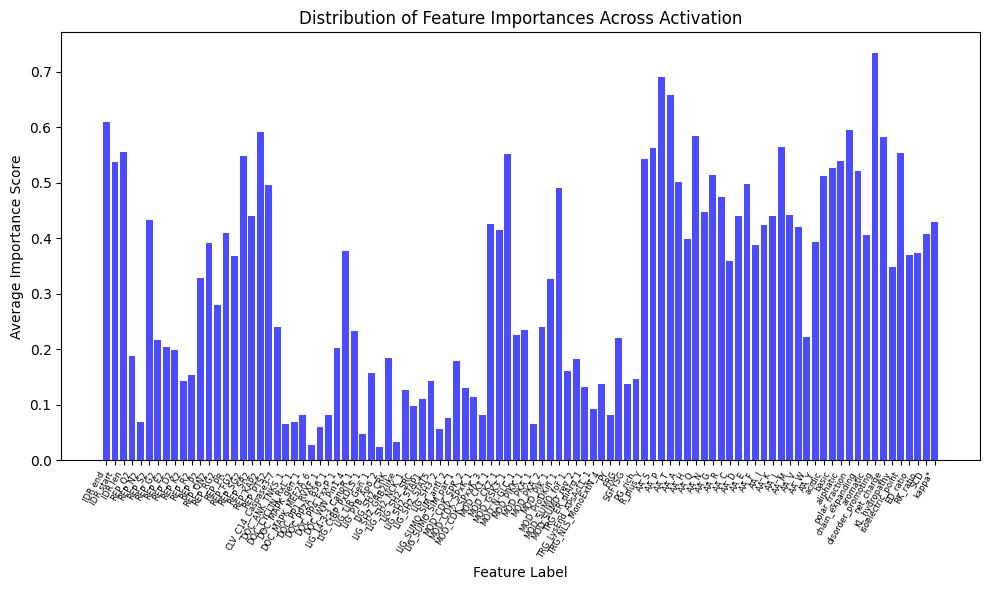

Feature importance distribution plot saved to 'feature_importance_distribution_by_label.png'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the feature labels are available (you can generate them if not)
# If you know the specific names of the features, replace 'Feature i' with their names
feature_labels = [f'Feature {i}' for i in range(activator_predicted_graphs[0].x.shape[1])]  # Example feature labels

# Initialize a dictionary to store feature importances for each feature label
feature_importances_by_label = {label: [] for label in feature_labels}
k = 0
# Loop through each graph in the dataset
for i, data in enumerate(activator_predicted_graphs):
    print(f"Processing graph {i+1}/{len(activator_predicted_graphs)}")

    # Extract node features and edge index
    x = data.x
    edge_index = data.edge_index

    # Generate explanations using the explainer for each graph
    explanation = explainer(x, edge_index)
    # path_feature_importance = f'importnace_A_{i+1}.pdf'
    # explanation.visualize_feature_importance(path_feature_importance, top_k=100)

    # Extract feature importances (assuming you're using node mask for feature importance)
    feature_importance = explanation.node_mask.cpu().numpy()  # Move to CPU if necessary
    print(f"Feature importance shape: {feature_importance.shape}")

    # Store the feature importances for this graph by feature label
    for idx, importance in enumerate(np.sum(feature_importance, axis=0)):  # Averaging across nodes
        feature_importances_by_label[feature_labels[idx]].append(importance)


#feature_importances_by_label.keys()
plt.figure(figsize=(10, 6))

# Convert feature importances to an array for plotting
means = [np.mean(np.nan_to_num(feature_importances_by_label[label], nan=0)) for label in feature_labels]


# Plot the means and standard deviations as a bar chart with error bars
plt.bar(labels, means, alpha=0.7, color='blue')
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances Across Activation")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()

# Save the plot locally
plt.savefig('feature_importance_distribution_by_label_activator.png')
# Save plot to the explainer folder
plt.show()
print(f"Feature importance distribution plot saved to 'feature_importance_distribution_by_label.png'")


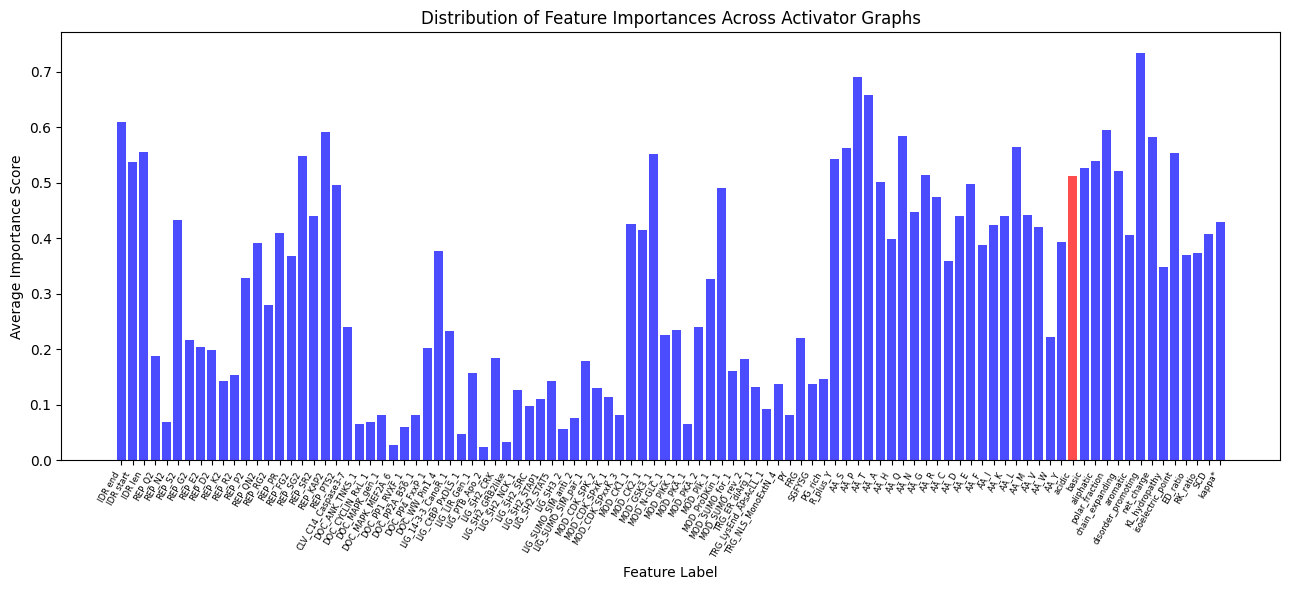

Feature importance distribution plot saved to 'feature_importance_distribution_by_label_activator.png'


In [ ]:
#feature_importances_by_label.keys()
plt.figure(figsize=(13, 6))
# Plot the means and standard deviations as a bar chart with error bars
# Set bar colors, making 'acidic' red
colors = ['red' if label == 'acidic' else 'blue' for label in labels]
plt.bar(labels, means, alpha=0.7, color=colors)
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances Across Activator Graphs")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()

# Save the plot locally
plt.savefig('feature_importance_distribution_by_label_activator.png')
# Save plot to the explainer folder
plt.show()
print(f"Feature importance distribution plot saved to 'feature_importance_distribution_by_label_activator.png'")


## Run explainer on repressor graphs

Processing graph 1/7
Feature importance shape: (1, 98)
Processing graph 2/7
Feature importance shape: (3, 98)
Processing graph 3/7
Feature importance shape: (1, 98)
Processing graph 4/7
Feature importance shape: (2, 98)
Processing graph 5/7
Feature importance shape: (2, 98)
Processing graph 6/7
Feature importance shape: (1, 98)
Processing graph 7/7
Feature importance shape: (1, 98)


<Figure size 1300x600 with 0 Axes>

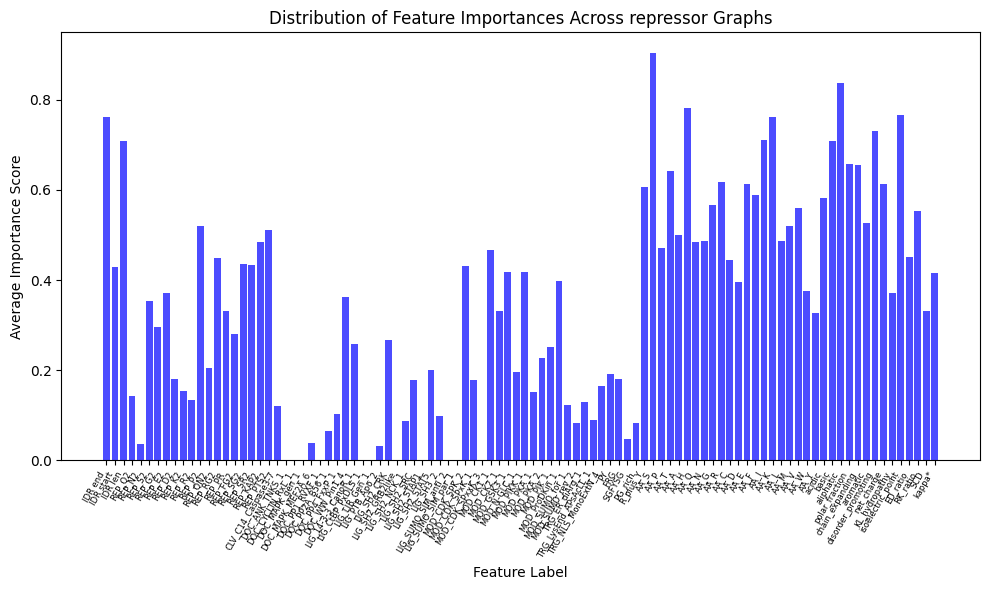

Feature importance distribution plot saved to 'feature_importance_distribution_by_label_repressor.png'


In [ ]:
#feature_importances_by_label.keys()
plt.figure(figsize=(13, 6))
# Assuming the feature labels are available (you can generate them if not)
# If you know the specific names of the features, replace 'Feature i' with their names
feature_labels = [f'Feature {i}' for i in range(repressor_predicted_graphs[0].x.shape[1])]  # Example feature labels

# Initialize a dictionary to store feature importances for each feature label
feature_importances_by_label = {label: [] for label in feature_labels}
k = 0
# Loop through each graph in the dataset
for i, data in enumerate(repressor_predicted_graphs):
    print(f"Processing graph {i+1}/{len(repressor_predicted_graphs)}")

    # Extract node features and edge index
    x = data.x
    edge_index = data.edge_index

    # Generate explanations using the explainer for each graph
    explanation = explainer(x, edge_index)
    # path_feature_importance = f'importnace_A_{i+1}.pdf'
    # explanation.visualize_feature_importance(path_feature_importance, top_k=100)

    # Extract feature importances (assuming you're using node mask for feature importance)
    feature_importance = explanation.node_mask.cpu().numpy()  # Move to CPU if necessary
    print(f"Feature importance shape: {feature_importance.shape}")

    # Store the feature importances for this graph by feature label
    for idx, importance in enumerate(np.sum(feature_importance, axis=0)):  # Averaging across nodes
        feature_importances_by_label[feature_labels[idx]].append(importance)


#feature_importances_by_label.keys()
plt.figure(figsize=(10, 6))

# Convert feature importances to an array for plotting
means = [np.mean(np.nan_to_num(feature_importances_by_label[label], nan=0)) for label in feature_labels]
# Set bar colors, making 'acidic' red
colors = ['red' if label == 'acidic' else 'blue' for label in labels]

# Plot the means and standard deviations as a bar chart with error bars
plt.bar(labels, means, alpha=0.7, color='blue')
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances Across repressor Graphs")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()

# Save the plot locally
plt.savefig('feature_importance_distribution_by_label_repressor.png')
# Save plot to the explainer folder
plt.show()
print(f"Feature importance distribution plot saved to 'feature_importance_distribution_by_label_repressor.png'")


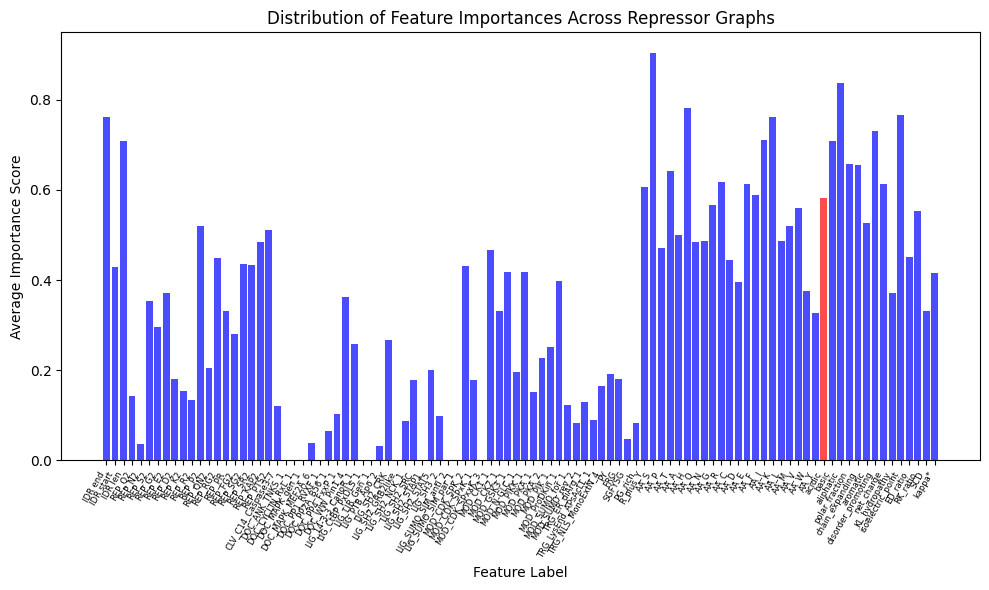

Feature importance distribution plot saved to 'feature_importance_distribution_by_label_repressor.png'


In [ ]:
plt.figure(figsize=(10, 6))

# Convert feature importances to an array for plotting
means = [np.mean(np.nan_to_num(feature_importances_by_label[label], nan=0)) for label in feature_labels]

# Set bar colors, making 'acidic' red
colors = ['red' if label == 'acidic' else 'blue' for label in labels]

# Plot the means as a bar chart with specified colors
plt.bar(labels, means, alpha=0.7, color=colors)
plt.xticks(rotation=60, ha='right', fontsize=6)
plt.title("Distribution of Feature Importances Across Repressor Graphs")
plt.xlabel("Feature Label")
plt.ylabel("Average Importance Score")
plt.tight_layout()

# Save the plot locally
plt.savefig('feature_importance_distribution_by_label_repressor.png')
# Display the plot
plt.show()

print(f"Feature importance distribution plot saved to 'feature_importance_distribution_by_label_repressor.png'")


In [ ]:
len(activator_predicted_graphs)

55

### Feature differences across activator and repressor features

In [ ]:
import pandas as pd
all_features = []

for data in activator_predicted_graphs:
    all_features.append(data.x.numpy())

# Concatenate all feature matrices
all_features = np.vstack(all_features)

# Convert to DataFrame
features_df = pd.DataFrame(all_features)

# Calculate statistics
mean_features = features_df.mean()
std_features = features_df.std()
print("Mean of features:\n", mean_features)
print("Standard deviation of features:\n", std_features)

Mean of features:
 0     295.859985
1     158.039993
2     138.820007
3       0.760000
4       0.190000
         ...    
93      6.310762
94      0.234899
95     -0.030097
96      1.629027
97      0.283333
Length: 98, dtype: float32
Standard deviation of features:
 0     192.007584
1     179.210800
2     112.254448
3       1.787273
4       0.506424
         ...    
93      2.283090
94      0.650379
95      0.739496
96      4.719299
97      1.371263
Length: 98, dtype: float32


In [ ]:
features_df.columns = labels

features_df= features_df.iloc[:, 3:]

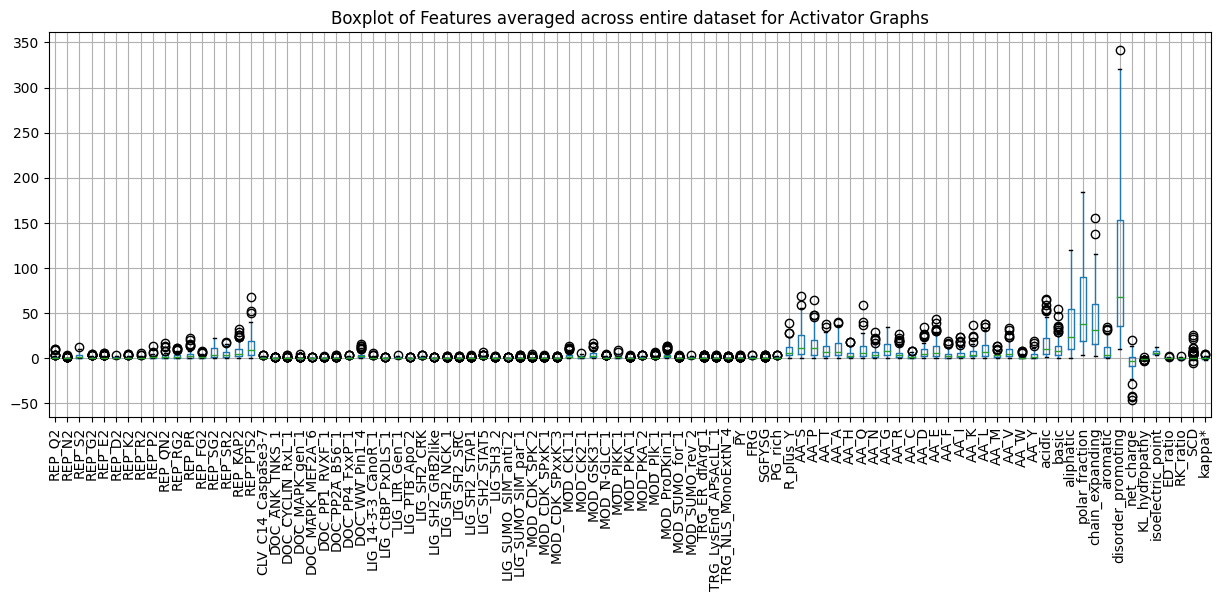

In [ ]:
|import matplotlib.pyplot as plt
import seaborn as sns

# # Histogram of features
# features_df.hist(bins=30, figsize=(15, 10))
# plt.suptitle('Feature Distributions')
# plt.show()

# Box plot for visualizing outliers
plt.figure(figsize=(15, 5))
features_df.boxplot()
plt.title('Boxplot of Features averaged across entire dataset for Activator Graphs')
plt.xticks(rotation=90)
plt.show()

# # Correlation heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(features_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Feature Correlation Heatmap')
# plt.show()


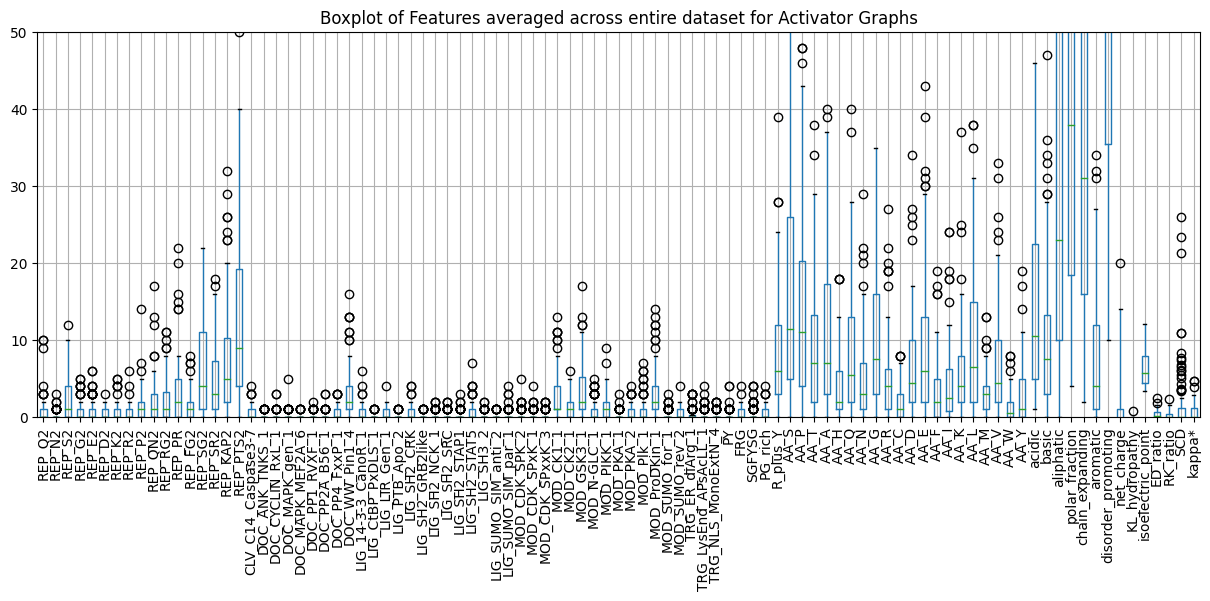

In [ ]:

# Box plot for visualizing outliers
plt.figure(figsize=(15, 5))
features_df.boxplot()
plt.title('Boxplot of Features averaged across entire dataset for Activator Graphs')
plt.ylim(0, 50)  # Set the y-axis limit
plt.xticks(rotation=90)
plt.show()

<Figure size 1500x500 with 0 Axes>

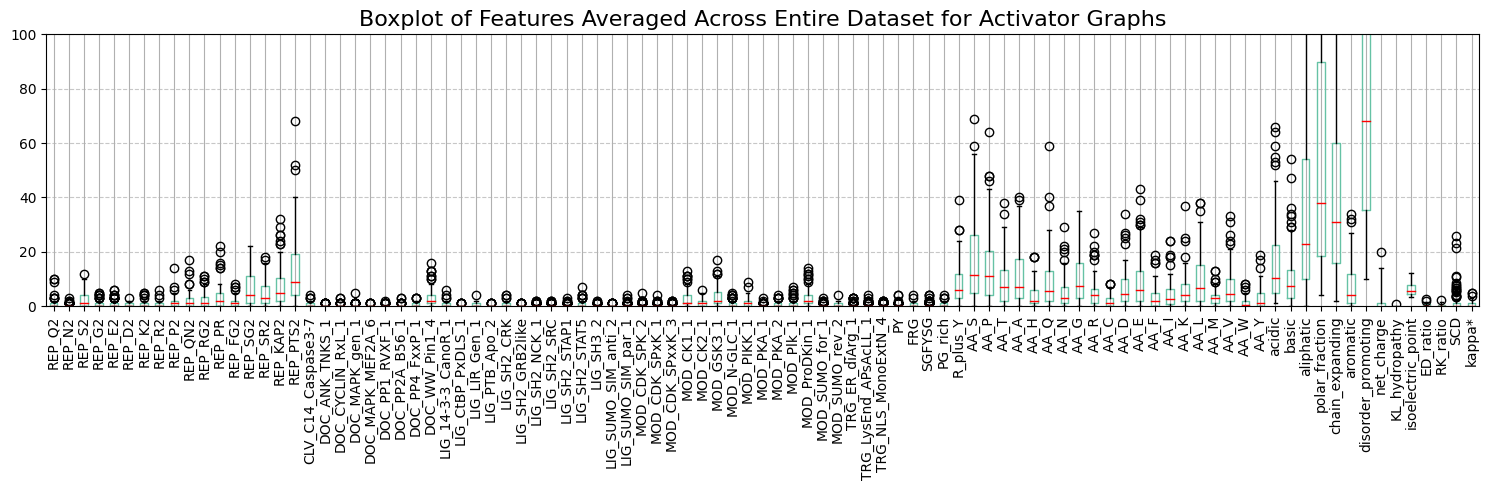

In [ ]:
# Improved boxplot visualization for Activator Graphs
plt.figure(figsize=(15, 5))

# Create the boxplot with customized aesthetics
import matplotlib.pyplot as plt

# Assuming features_df is defined and contains your data
# Sample DataFrame for demonstration if needed
# features_df = pd.DataFrame(np.random.rand(100, 10) * 100)  # Uncomment this if you need to generate sample data

# Improved boxplot visualization for Activator Graphs
plt.figure(figsize=(15, 5))

# Create the boxplot with customized aesthetics
box = features_df.boxplot(color=dict(boxes='#66c2a5', whiskers='black', medians='red', caps='black'))

# Add title and labels
plt.title('Boxplot of Features Averaged Across Entire Dataset for Activator Graphs', fontsize=16)
plt.ylim(0, 100)  # Set the y-axis limit
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()


In [ ]:
all_features = []

for data in repressor_predicted_graphs:
    all_features.append(data.x.numpy())

# Concatenate all feature matrices
all_features = np.vstack(all_features)

# Convert to DataFrame
features_df_repressor = pd.DataFrame(all_features)

# Calculate statistics
mean_features_repres = features_df.mean()
std_features_repres = features_df.std()
print("Mean of features:\n", mean_features)
print("Standard deviation of features:\n", std_features)
features_df_repressor.columns = labels

features_df_repressor= features_df_repressor.iloc[:, 3:]

Mean of features:
 0     295.859985
1     158.039993
2     138.820007
3       0.760000
4       0.190000
         ...    
93      6.310762
94      0.234899
95     -0.030097
96      1.629027
97      0.283333
Length: 98, dtype: float32
Standard deviation of features:
 0     192.007584
1     179.210800
2     112.254448
3       1.787273
4       0.506424
         ...    
93      2.283090
94      0.650379
95      0.739496
96      4.719299
97      1.371263
Length: 98, dtype: float32


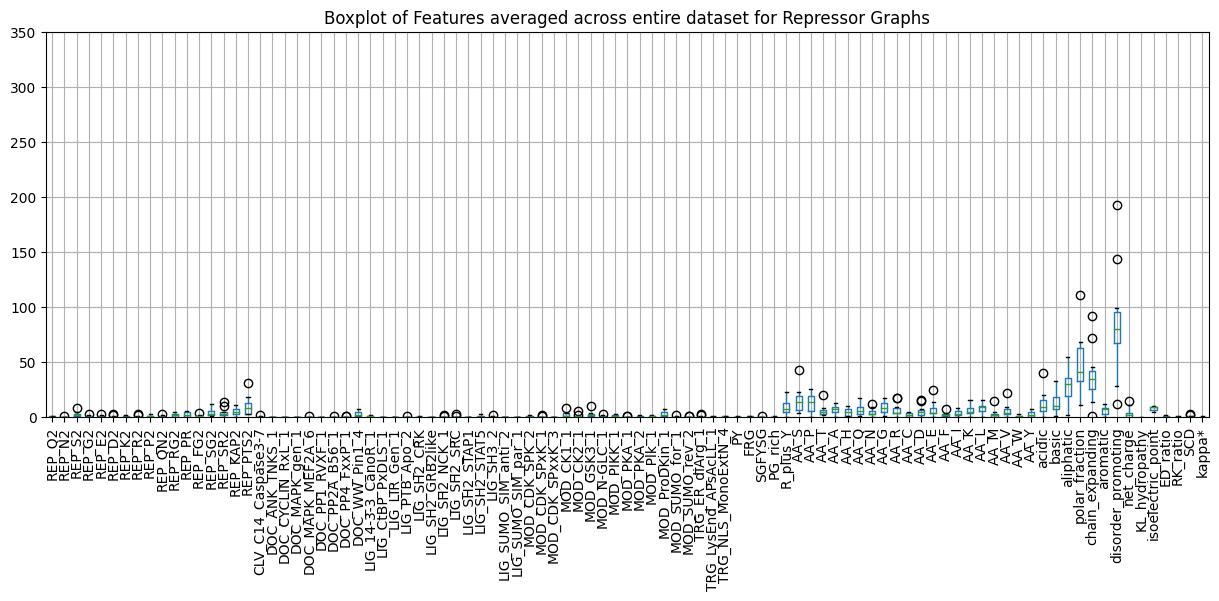

In [ ]:
plt.figure(figsize=(15, 5))
features_df_repressor.boxplot()
plt.title('Boxplot of Features averaged across entire dataset for Repressor Graphs')
plt.xticks(rotation=90)
plt.ylim(0, 350)  # Set the y-axis limit
plt.show()

# # Correlation heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(features_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Feature Correlation Heatmap')
# plt.show()


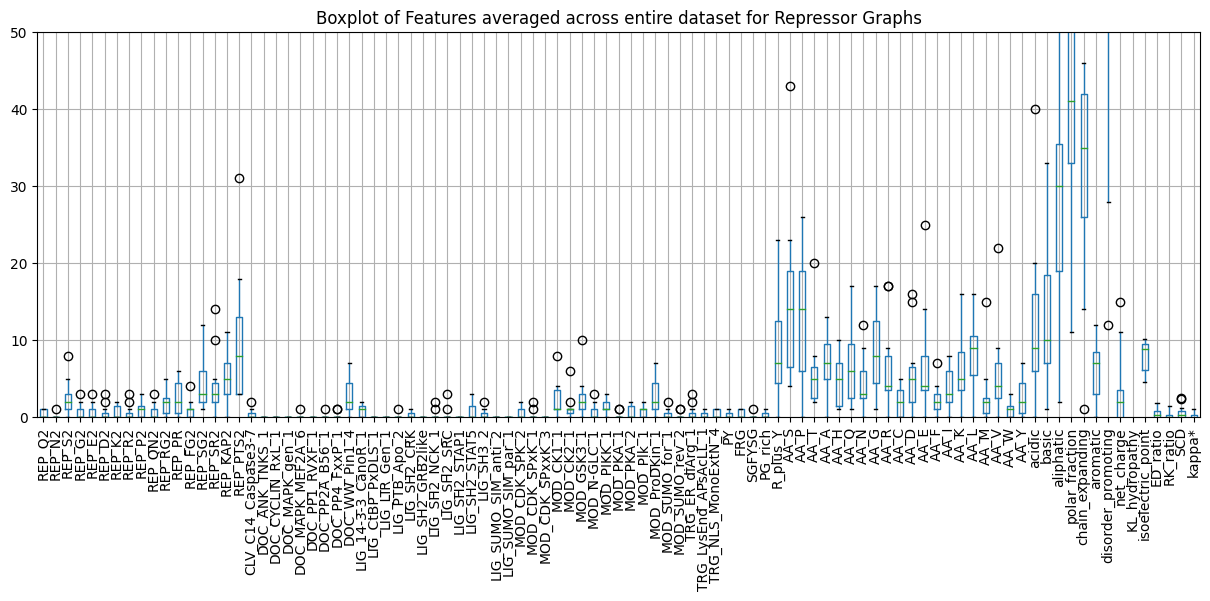

In [ ]:
plt.figure(figsize=(15, 5))
features_df_repressor.boxplot()
plt.title('Boxplot of Features averaged across entire dataset for Repressor Graphs')
plt.xticks(rotation=90)
plt.ylim(0, 50)  # Set the y-axis limit
plt.show()

# # Correlation heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(features_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Feature Correlation Heatmap')
# plt.show()

In [ ]:
features_df_repressor[["acidic"]].mean()

,0
acidic,12.545455


In [ ]:
features_df[["acidic"]].mean()

,0
acidic,16.07


In [ ]:
features_df

,REP_Q2,REP_N2,REP_S2,REP_G2,REP_E2,REP_D2,REP_K2,REP_R2,REP_P2,REP_QN2,...,chain_expanding,aromatic,disorder_promoting,net_charge,KL_hydropathy,isoelectric_point,ED_ratio,RK_ratio,SCD,kappa*
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,22.0,2.0,47.0,-3.0,-0.652459,4.872070,0.000000,0.693147,-0.617877,1.942774
1,4.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0,...,48.0,19.0,186.0,-2.0,-0.730290,6.463867,0.356675,0.133531,-0.216026,-2.456514
2,1.0,0.0,1.0,2.0,6.0,1.0,5.0,1.0,3.0,3.0,...,100.0,10.0,182.0,-23.0,-0.706391,4.528320,1.049822,-1.427116,3.641572,3.874544
3,0.0,0.0,1.0,1.0,3.0,1.0,4.0,1.0,2.0,4.0,...,79.0,0.0,125.0,-17.0,-1.433548,4.463867,0.619039,-0.262364,3.530188,4.677642
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,9.0,3.0,18.0,4.0,-0.822222,10.024414,1.098612,0.000000,0.317160,-0.097059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,7.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,60.0,7.0,150.0,-17.0,-0.408716,4.477539,0.287682,-0.223144,4.286916,-0.222305
96,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,16.0,1.0,49.0,-5.0,-0.534783,4.668945,0.980829,1.609438,0.469536,0.095171
97,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,22.0,2.0,48.0,-8.0,-0.624194,3.838867,1.098612,1.098612,1.747658,0.167396
98,1.0,0.0,5.0,3.0,4.0,1.0,0.0,6.0,4.0,1.0,...,116.0,11.0,234.0,-10.0,-0.851864,5.198242,0.693147,1.029619,-5.120220,2.147290


In [ ]:
features_df_repressor

,REP_Q2,REP_N2,REP_S2,REP_G2,REP_E2,REP_D2,REP_K2,REP_R2,REP_P2,REP_QN2,...,chain_expanding,aromatic,disorder_promoting,net_charge,KL_hydropathy,isoelectric_point,ED_ratio,RK_ratio,SCD,kappa*
0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.0,10.0,93.0,3.0,-0.588889,8.852539,0.980829,0.287682,-0.867134,-0.410329
1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,...,34.0,7.0,78.0,-4.0,-0.322609,6.170898,-0.470004,0.223144,0.298517,-1.753920
2,0.0,0.0,5.0,1.0,1.0,3.0,2.0,0.0,0.0,0.0,...,35.0,1.0,83.0,-10.0,-1.478125,4.606445,-1.223775,-0.336472,1.161049,1.058314
3,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,1.0,...,31.0,6.0,99.0,-4.0,-0.526619,6.161133,-1.252763,1.386294,0.280979,-1.485092
4,0.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,0.0,...,46.0,10.0,80.0,11.0,-0.973950,9.756836,0.510826,-0.530628,2.467303,0.590460
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,12.0,1.0,-0.713333,8.764648,0.000000,-0.693147,0.000000,NaN
6,1.0,1.0,8.0,0.0,3.0,2.0,0.0,3.0,1.0,3.0,...,92.0,12.0,193.0,-14.0,-0.858519,4.635742,0.485508,0.587787,0.441423,-0.502295
7,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,14.0,0.0,28.0,2.0,-0.934211,9.401367,1.791759,-0.693147,-0.135660,-1.304858
8,1.0,0.0,3.0,1.0,0.0,0.0,2.0,2.0,0.0,2.0,...,72.0,7.0,144.0,15.0,-1.382873,10.165039,1.098612,0.057158,2.336213,-0.680090
9,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,35.0,7.0,79.0,3.0,-0.394690,8.790039,-0.182322,-0.587787,-0.097219,0.519989


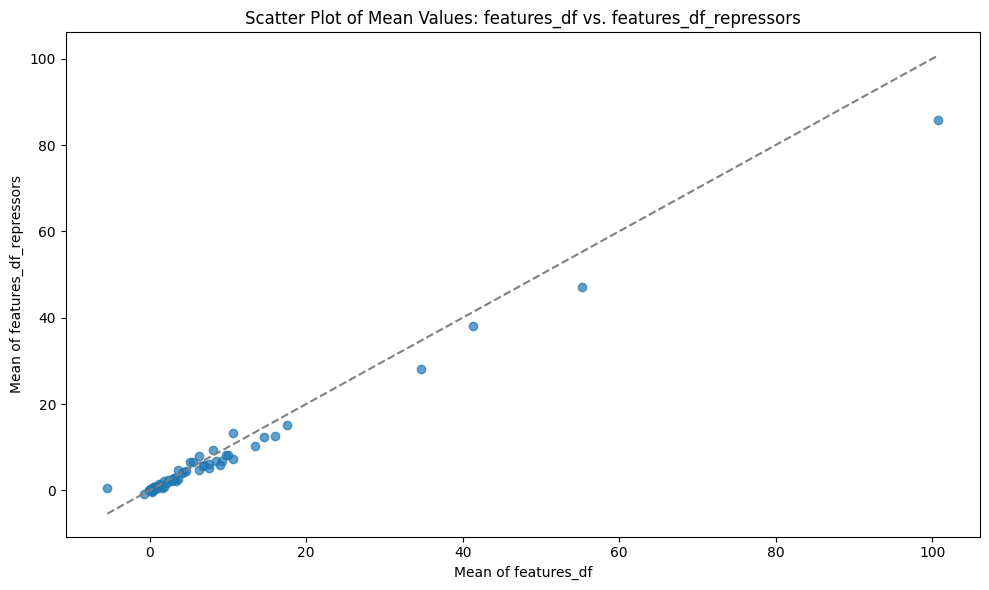

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean of each feature in both DataFrames
mean_features_df = features_df.mean()
mean_features_df_repressors = features_df_repressor.mean()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(mean_features_df, mean_features_df_repressors, alpha=0.7)

# Add labels and title
plt.xlabel('Mean of features_df')
plt.ylabel('Mean of features_df_repressors')
plt.title('Scatter Plot of Mean Values: features_df vs. features_df_repressors')

# Add a diagonal line for reference
min_val = min(mean_features_df.min(), mean_features_df_repressors.min())
max_val = max(mean_features_df.max(), mean_features_df_repressors.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
mean_features_df

,0
REP_Q2,0.760000
REP_N2,0.190000
REP_S2,2.340000
REP_G2,0.780000
REP_E2,0.850000
...,...
isoelectric_point,6.310762
ED_ratio,0.234899
RK_ratio,-0.030097
SCD,1.629027


In [ ]:
mean_features_df_repressors

,0
REP_Q2,0.363636
REP_N2,0.090909
REP_S2,2.363636
REP_G2,0.727273
REP_E2,0.727273
...,...
isoelectric_point,7.899414
ED_ratio,0.184214
RK_ratio,-0.010618
SCD,0.521122


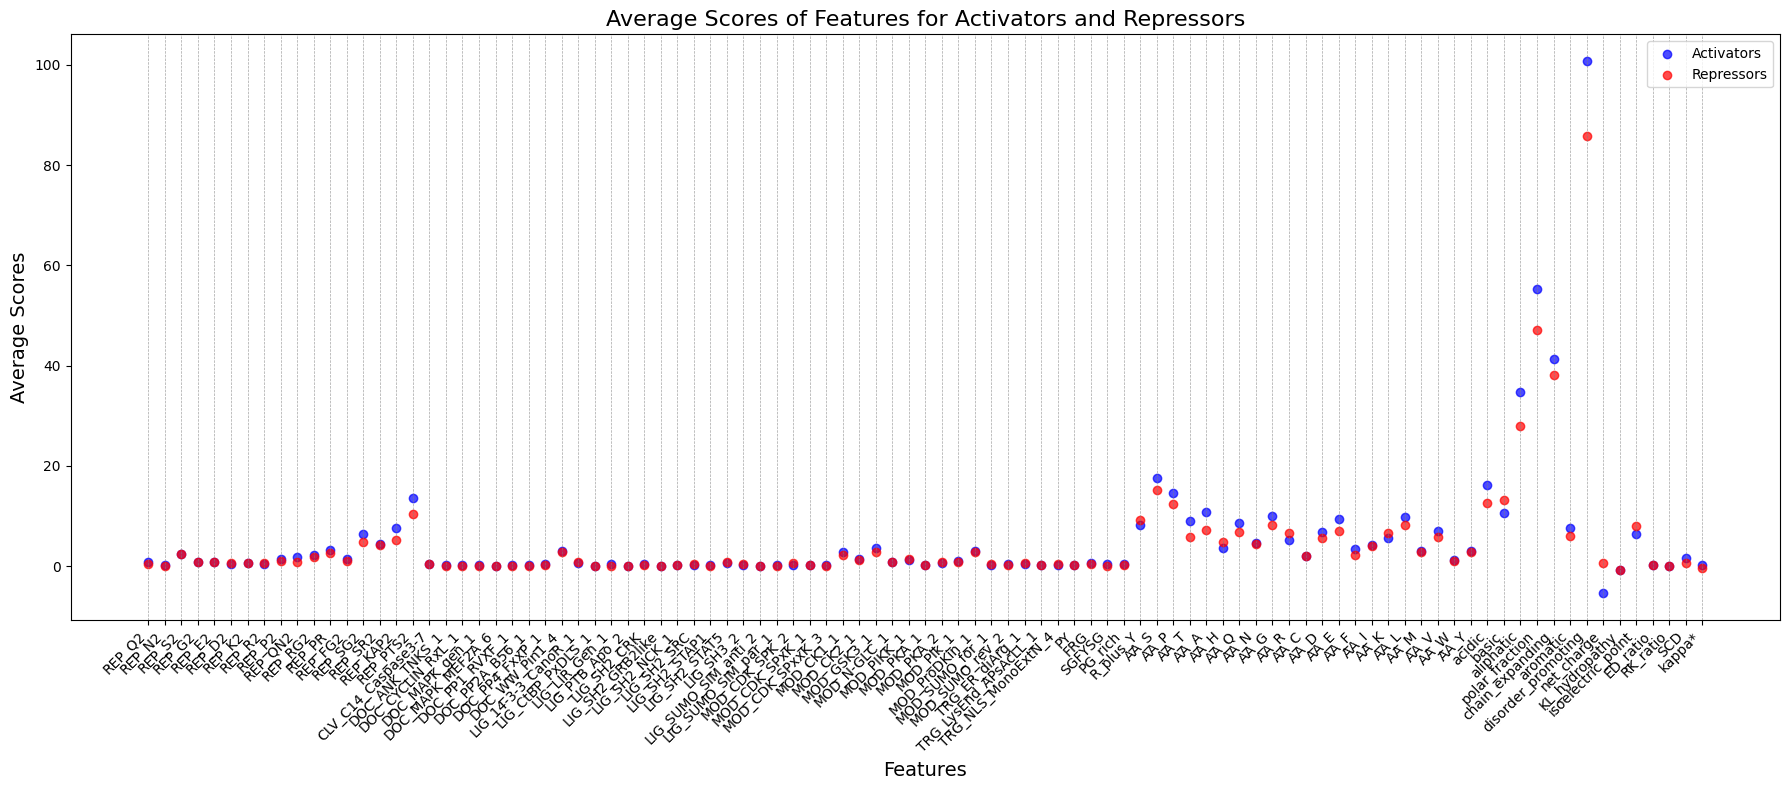

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of each feature in both DataFrames
mean_features_df = features_df.mean()
mean_features_df_repressors = features_df_repressor.mean()

# Get feature names for x-axis
features = mean_features_df.index

# Create the scatter plot
plt.figure(figsize=(18, 8))

# Plot activators (mean values from features_df)
plt.scatter(features, mean_features_df, color='blue', alpha=0.7, label='Activators')

# Plot repressors (mean values from features_df_repressors)
plt.scatter(features, mean_features_df_repressors, color='red', alpha=0.7, label='Repressors')
# Add vertical lines for each feature
for i, feature in enumerate(features):
    plt.axvline(x=feature, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
# Add labels and title
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average Scores', fontsize=14)
plt.title('Average Scores of Features for Activators and Repressors', fontsize=16)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()


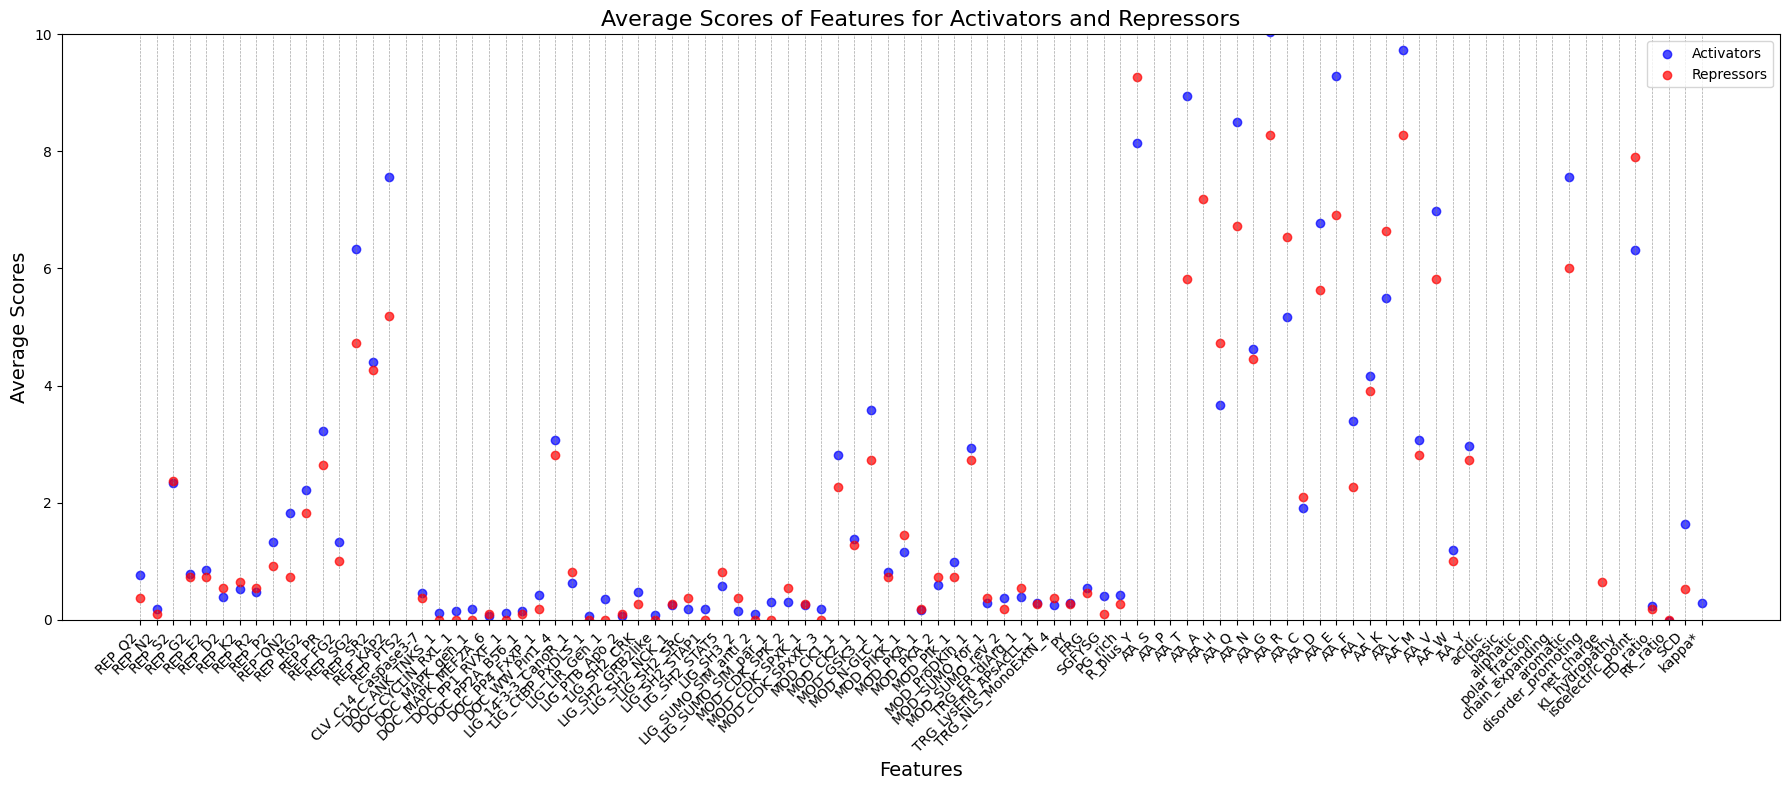

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of each feature in both DataFrames
mean_features_df = features_df.mean()
mean_features_df_repressors = features_df_repressor.mean()

# Get feature names for x-axis
features = mean_features_df.index

# Create the scatter plot
plt.figure(figsize=(18, 8))

# Plot activators (mean values from features_df)
plt.scatter(features, mean_features_df, color='blue', alpha=0.7, label='Activators')

# Plot repressors (mean values from features_df_repressors)
plt.scatter(features, mean_features_df_repressors, color='red', alpha=0.7, label='Repressors')
# Add vertical lines for each feature
for i, feature in enumerate(features):
    plt.axvline(x=feature, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
# Add labels and title
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average Scores', fontsize=14)
plt.title('Average Scores of Features for Activators and Repressors', fontsize=16)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.ylim(0,10)
# Add legend
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()


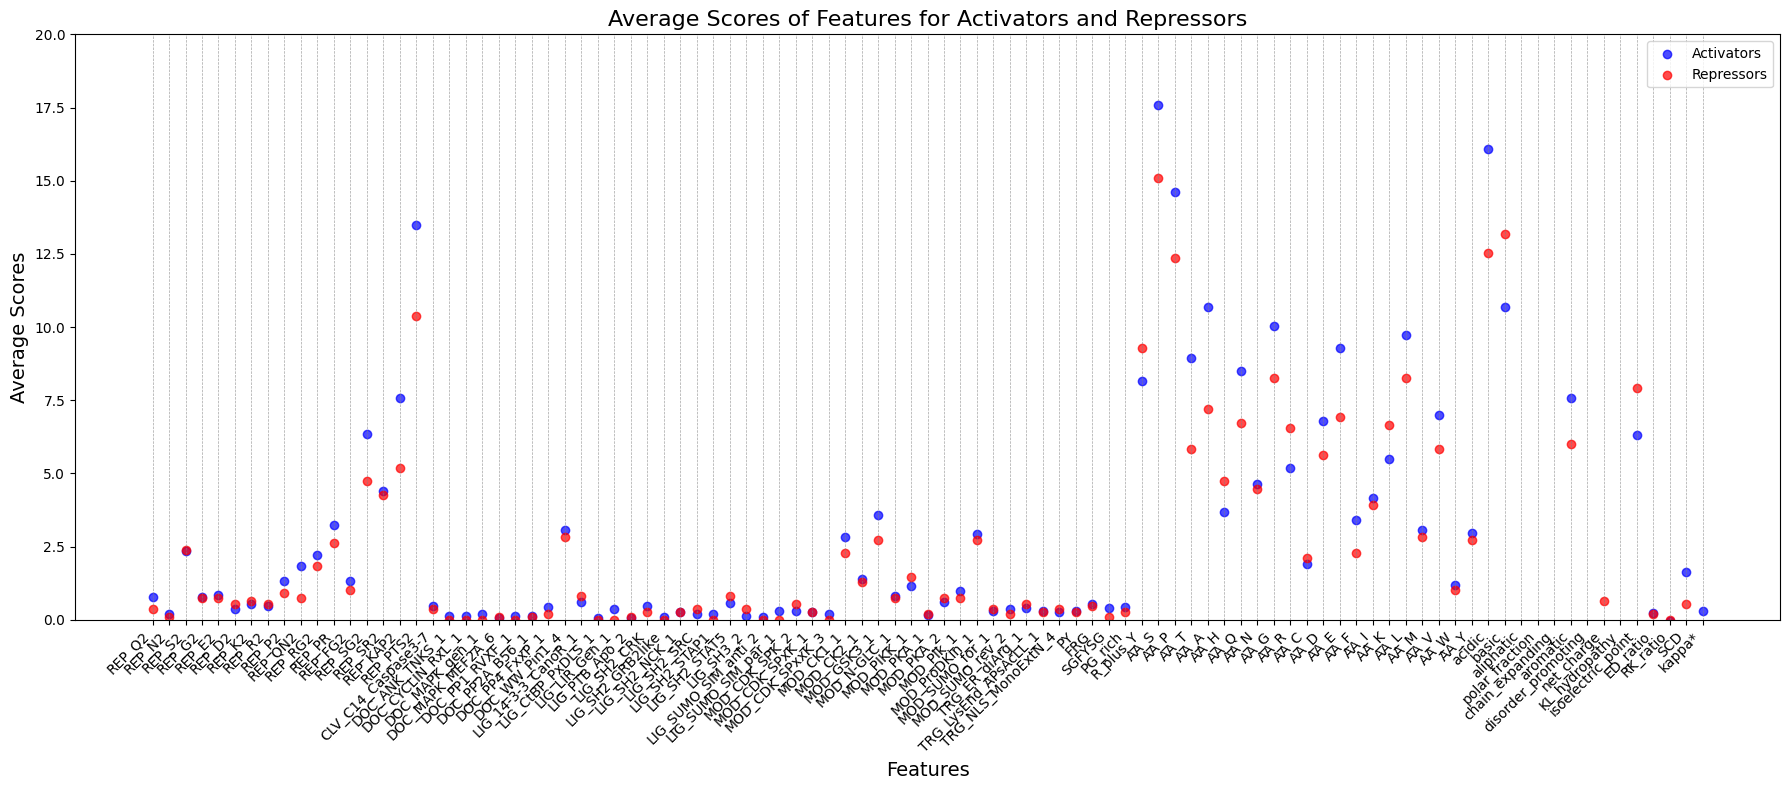

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean of each feature in both DataFrames
mean_features_df = features_df.mean()
mean_features_df_repressors = features_df_repressor.mean()

# Get feature names for x-axis
features = mean_features_df.index

# Create the scatter plot
plt.figure(figsize=(18, 8))

# Plot activators (mean values from features_df)
plt.scatter(features, mean_features_df, color='blue', alpha=0.7, label='Activators')

# Plot repressors (mean values from features_df_repressors)
plt.scatter(features, mean_features_df_repressors, color='red', alpha=0.7, label='Repressors')
# Add vertical lines for each feature
for i, feature in enumerate(features):
    plt.axvline(x=feature, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
# Add labels and title
plt.xlabel('Features', fontsize=14)
plt.ylabel('Average Scores', fontsize=14)
plt.title('Average Scores of Features for Activators and Repressors', fontsize=16)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.ylim(0,20)
# Add legend
plt.legend()

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()
